Используем Датасет adult_income для нахождения зависимостей между доходом человека и его характеристиками. Такая Задача может быть полезна банкам для Анализа клиентов.

In [30]:
import warnings

warnings.filterwarnings("ignore")

import numpy as np
import pandas as pd 
import matplotlib.pyplot as plt
import seaborn as sns
import sys
import os

from matplotlib.colors import ListedColormap
from datetime import datetime 
from pandas import Series, DataFrame 
from sklearn.preprocessing import LabelEncoder,OneHotEncoder

%matplotlib inline

RANDOM_STATE = 42

# Функции для работы с данными


In [31]:
def make_NaN(df):
    for col in df.columns:
        df[col][df[col] == ' ?'] = None
            
def find_NaN(df):
    nans = df.loc[:, df.isnull().any()].copy()
    print(nans.columns)
    nans = nans.isna().sum()
    print(nans)

# Анализ

In [32]:
pd.set_option('display.max_columns', 100)

Смотрим все ли правильно загрузилось

In [33]:
train = pd.read_csv("train.csv")
test = pd.read_csv("test.csv")
train.head()

,age,workclass,fnlwgt,education,education-num,marital-status,occupation,relationship,race,sex,capital-gain,capital-loss,hours-per-week,native-country,income
0,39,State-gov,77516,Bachelors,13,Never-married,Adm-clerical,Not-in-family,White,Male,2174,0,40,United-States,<=50K
1,50,Self-emp-not-inc,83311,Bachelors,13,Married-civ-spouse,Exec-managerial,Husband,White,Male,0,0,13,United-States,<=50K
2,38,Private,215646,HS-grad,9,Divorced,Handlers-cleaners,Not-in-family,White,Male,0,0,40,United-States,<=50K
3,53,Private,234721,11th,7,Married-civ-spouse,Handlers-cleaners,Husband,Black,Male,0,0,40,United-States,<=50K
4,28,Private,338409,Bachelors,13,Married-civ-spouse,Prof-specialty,Wife,Black,Female,0,0,40,Cuba,<=50K


In [34]:
train.shape

(32561, 15)

Типы каждого из признаков, видим проблему, что многие признаки имеют тип объект

In [35]:
train.dtypes

age                int64
workclass         object
fnlwgt             int64
education         object
education-num      int64
marital-status    object
occupation        object
relationship      object
race              object
sex               object
capital-gain       int64
capital-loss       int64
hours-per-week     int64
native-country    object
income            object
dtype: object

In [36]:
train.describe()

,age,fnlwgt,education-num,capital-gain,capital-loss,hours-per-week
count,32561.000000,3.256100e+04,32561.000000,32561.000000,32561.000000,32561.000000
mean,38.581647,1.897784e+05,10.080679,1077.648844,87.303830,40.437456
std,13.640433,1.055500e+05,2.572720,7385.292085,402.960219,12.347429
min,17.000000,1.228500e+04,1.000000,0.000000,0.000000,1.000000
25%,28.000000,1.178270e+05,9.000000,0.000000,0.000000,40.000000
50%,37.000000,1.783560e+05,10.000000,0.000000,0.000000,40.000000
75%,48.000000,2.370510e+05,12.000000,0.000000,0.000000,45.000000
max,90.000000,1.484705e+06,16.000000,99999.000000,4356.000000,99.000000


In [37]:
train.describe(include=['object'])

,workclass,education,marital-status,occupation,relationship,race,sex,native-country,income
count,32561,32561,32561,32561,32561,32561,32561,32561,32561
unique,9,16,7,15,6,5,2,42,2
top,Private,HS-grad,Married-civ-spouse,Prof-specialty,Husband,White,Male,United-States,<=50K
freq,22696,10501,14976,4140,13193,27816,21790,29170,24720


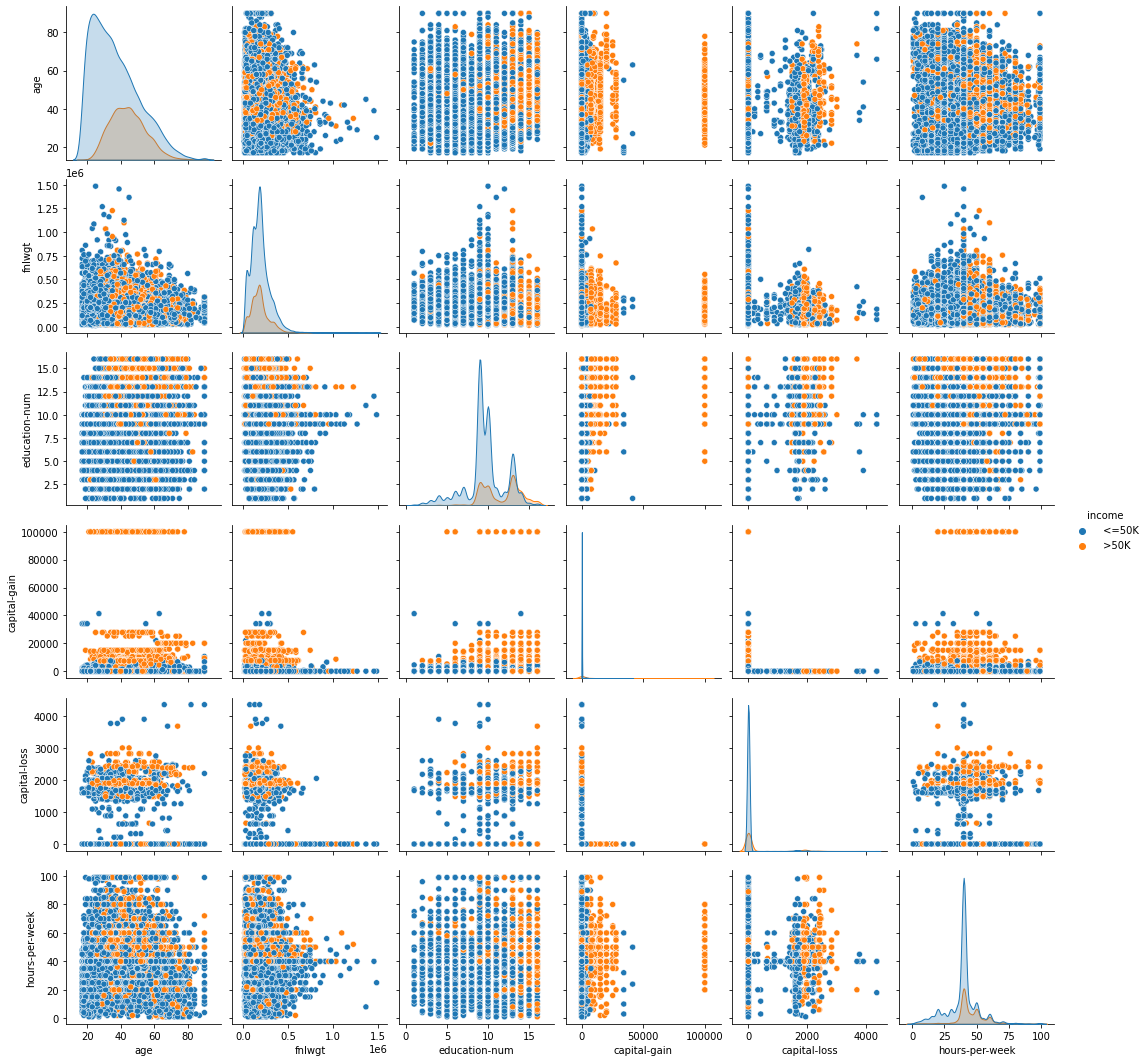

In [38]:
cols = ['age', 'fnlwgt',  'education-num',
       'capital-gain', 'capital-loss','hours-per-week','income']
sns_plot = sns.pairplot(train[cols].dropna(), hue = 'income')

Посмотрим на корреляции

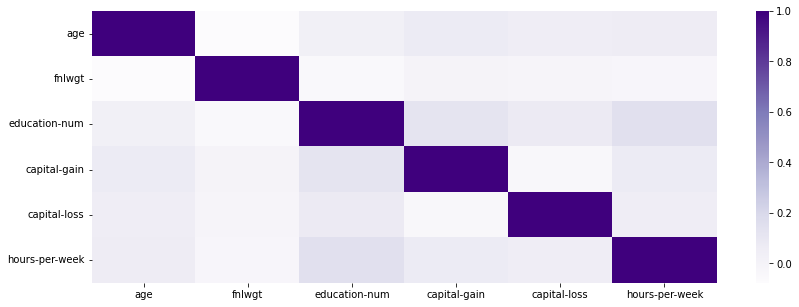

In [39]:
fig = plt.figure(figsize= (14,5))
sns.heatmap(train[cols].dropna().corr(), cmap = 'Purples')

Уникальные значения в каждом из признаков

In [40]:
unique_counts = pd.DataFrame.from_records([(col, train[col].dtype, train[col].nunique()) for col in train.columns],
                          columns=['Column_Name', 'Type', 'Num_Unique']).sort_values(by=['Num_Unique'])
unique_counts

,Column_Name,Type,Num_Unique
9,sex,object,2
14,income,object,2
8,race,object,5
7,relationship,object,6
5,marital-status,object,7
1,workclass,object,9
6,occupation,object,15
3,education,object,16
4,education-num,int64,16
13,native-country,object,42


Распределение данных в каждом из признаков

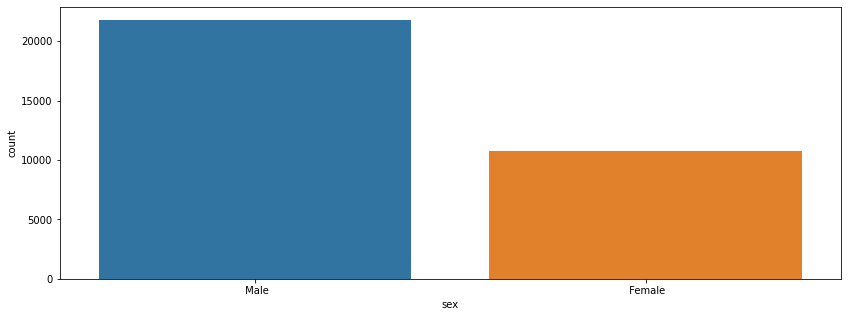

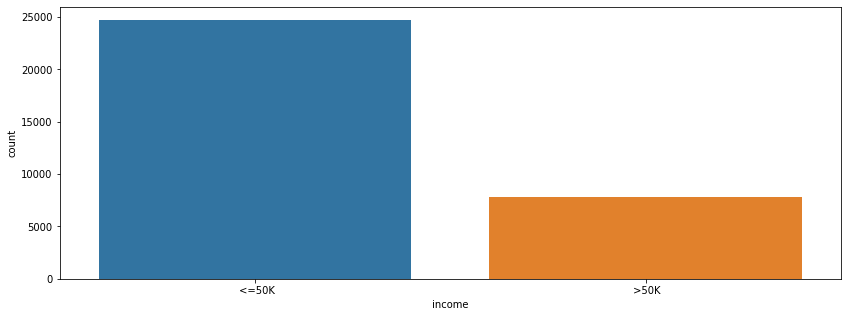

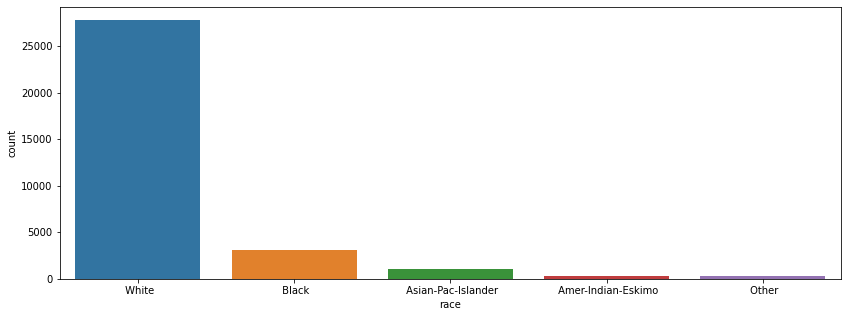

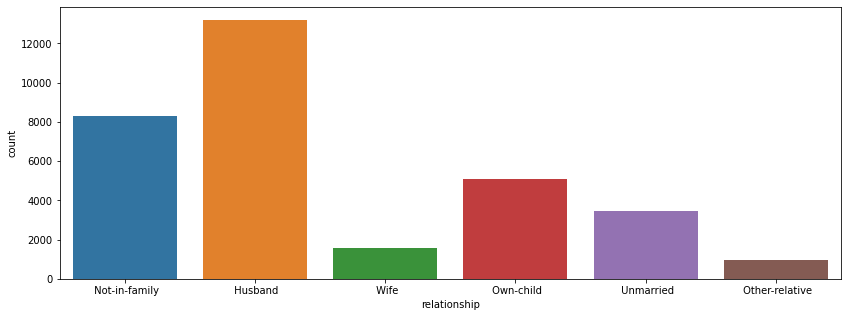

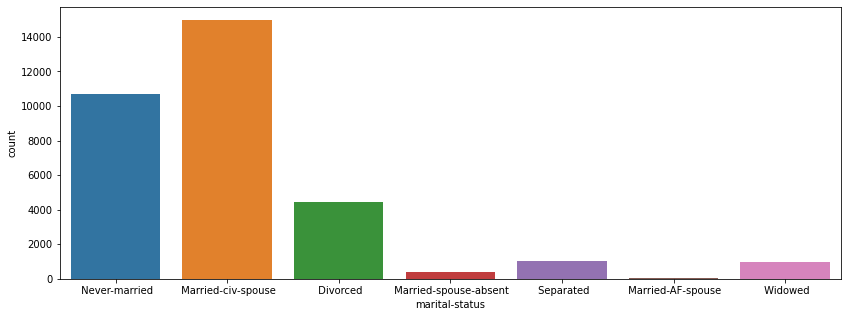

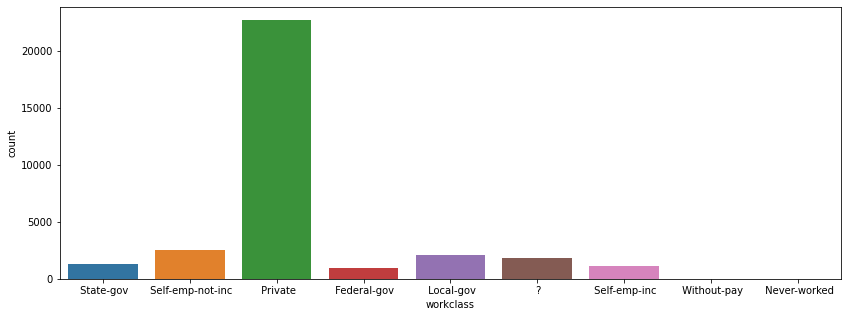

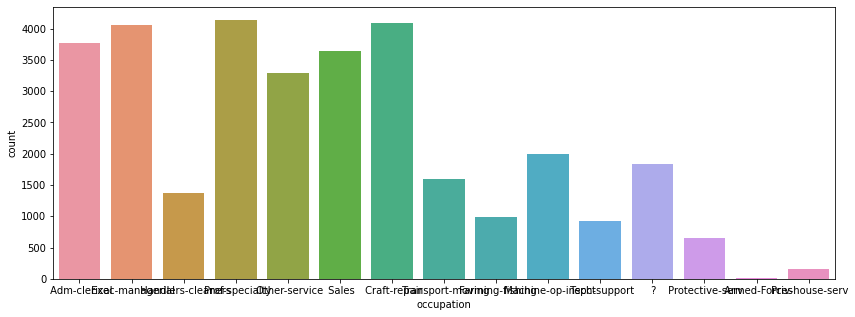

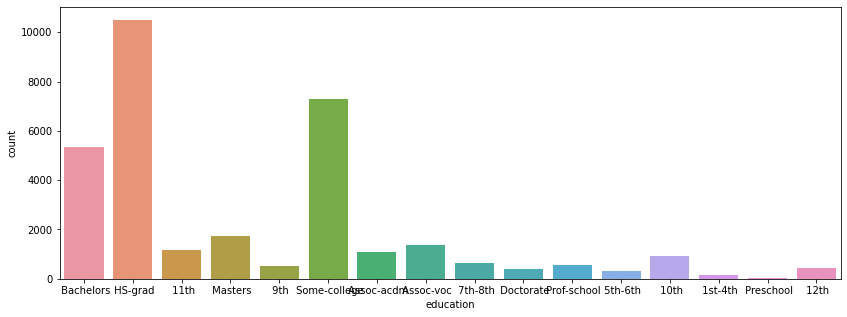

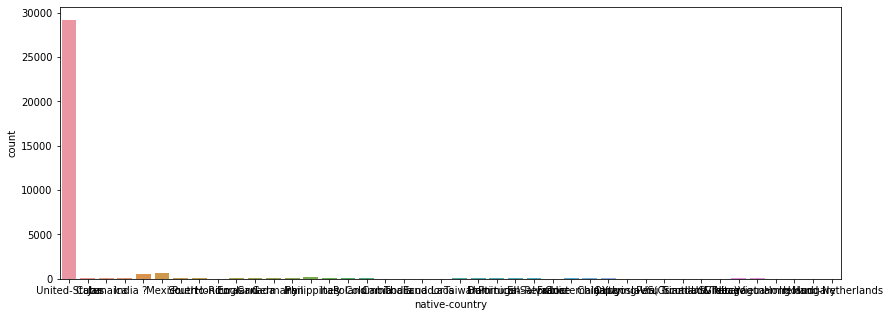

In [41]:
cols = ['sex', 'income',  'race',
       'relationship', 'marital-status','workclass', 'occupation', 'education', 'native-country']
for c in cols:    
    fig = plt.figure(figsize= (14,5))
    sns.countplot(train[c])
  

Преобразуем колонку income, распределяем доходы на больше 50к в год и меньше

In [42]:
train.income.replace([' >50K', ' <=50K'], [1, 0], inplace=True) 
test.income.replace([' >50K.', ' <=50K.'], [1, 0], inplace=True)

train['income'] = train['income'].astype('int32')
test['income'] = test['income'].astype('int32')

Заполняем пропущенные значения NaN

In [43]:
make_NaN(train)
make_NaN(test)

Графически видим, что существует зависимость между возрастом и доходом

<Figure size 2880x2880 with 0 Axes>

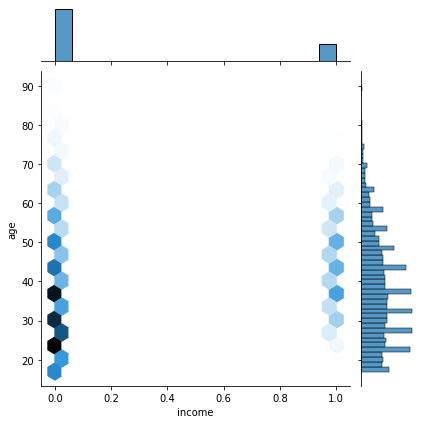

In [44]:
# ДОСТАТОК-ВОЗРАСТ
fig = plt.figure(figsize=(40, 40))
sns.jointplot(x='income', y='age', data=train, kind ='hex',gridsize=20)

Посмотрим на зависимость между доходом и номер обучения.

Видим, что люди с большим доходом имеют большой заработок (12-16)

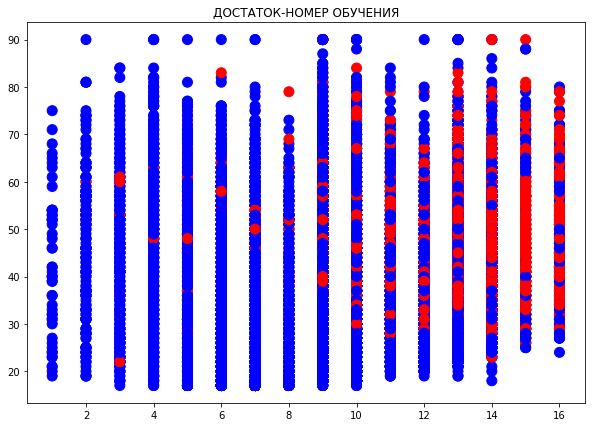

In [45]:
# ДОСТАТОК-НОМЕР ОБУЧЕНИЯ-ВОЗРАСТ
colors = ListedColormap(["blue", "red"])
# 0 - blue
# 1 - red
plt.figure(figsize=(10,7))
plt.title("ДОСТАТОК-НОМЕР ОБУЧЕНИЯ")
plt.scatter(train['education-num'], train['age'], c=train['income'], cmap=colors, s=100)
plt.show()

График зависимости заработка от количества часов в неделю.

Видим, что набиольший зарабаток у людей, которые работают 40-60 часов в неделю

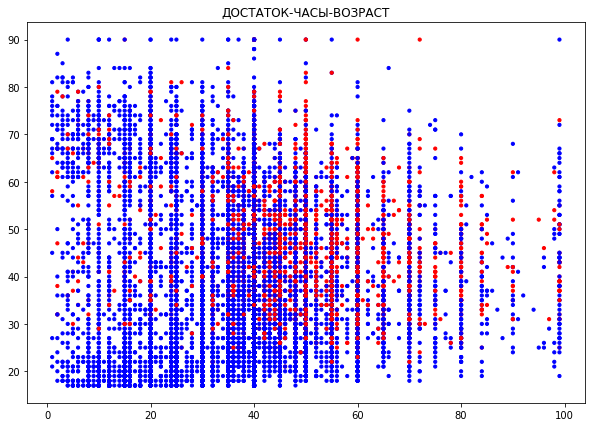

In [46]:
# ДОСТАТОК-ЧАСЫ-ВОЗРАСТ
colors = ListedColormap(["blue", "red"])
plt.figure(figsize=(10,7))
plt.title("ДОСТАТОК-ЧАСЫ-ВОЗРАСТ")
plt.scatter(train['hours-per-week'], train['age'], c=train['income'], cmap=colors, s=10)
plt.show()

Посмотрим зависмость заработка от пола.

Видим, что мужчины зарабатывают больше, чем женщины

<BarContainer object of 4 artists>

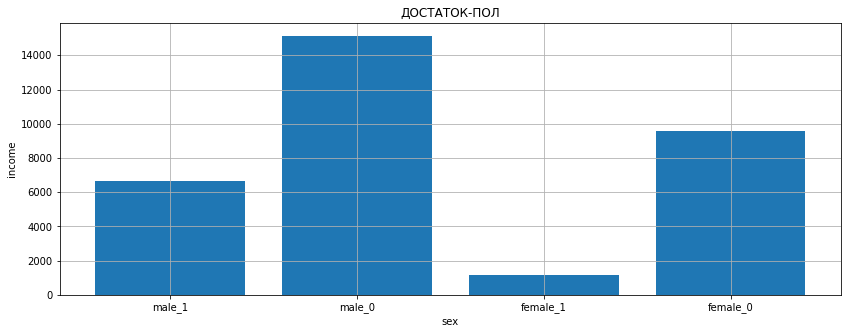

In [47]:
# ДОСТАТОК-ПОЛ
sex = ['male_1','male_0', 'female_1', 'female_0']

male_1 = train[train.sex == ' Male'][['income']].income.sum()
male_0 = train[(train.sex == ' Male') & (train.income == 0)][['sex']].count()
female_1 = train[train.sex == ' Female'][['income']].income.sum()
female_0 = train[(train.sex == ' Female') & (train.income == 0)][['sex']].count()

cls = [male_1, male_0, female_1, female_0]

fig = plt.figure(figsize=(14,5))
ax1 = fig.add_subplot()
ax1.set_xlabel('sex')
ax1.set_ylabel('income')
ax1.set_title('ДОСТАТОК-ПОЛ')
ax1.grid()
ax1.bar(sex, cls) 

Посмортим теперь зависимость дохода от вида образования.

Видим, что существует сильная зависимость от вида образования.

Хотя, можно считать, что большинство людей обучались в общественной школе и поэтому такое распредление.

<BarContainer object of 16 artists>

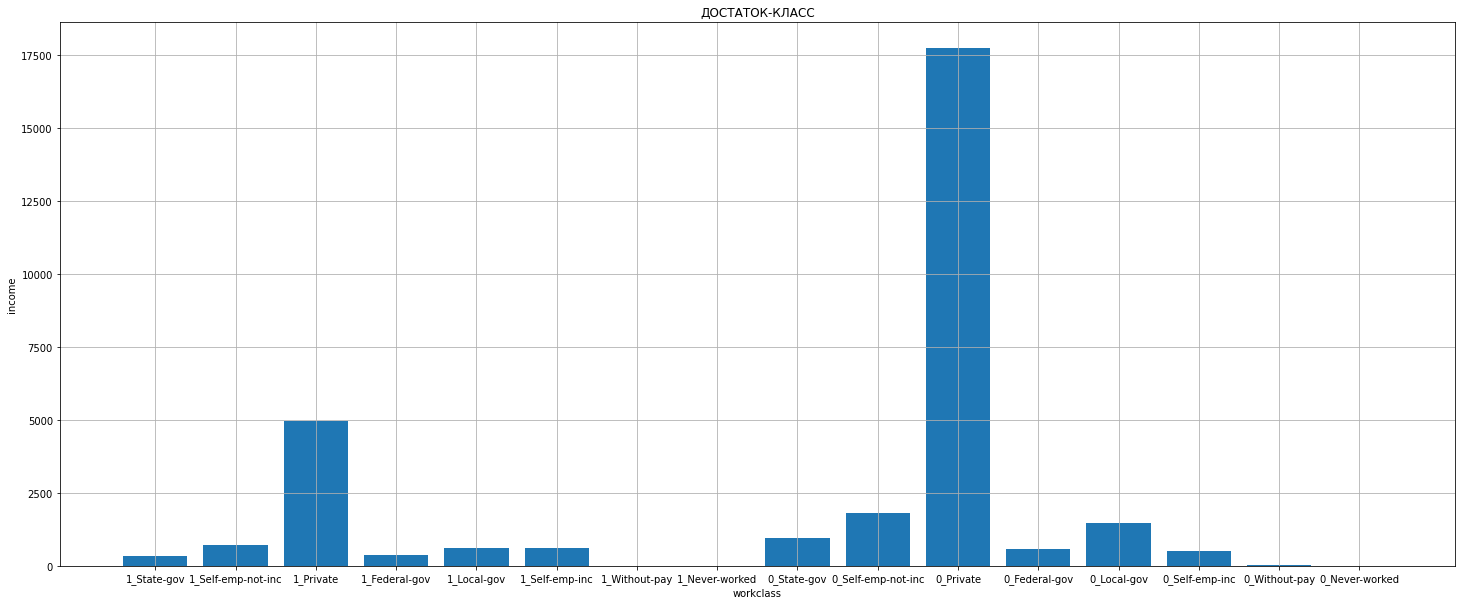

In [48]:

cls = ['1_State-gov', '1_Self-emp-not-inc', '1_Private', '1_Federal-gov', '1_Local-gov',
 '1_Self-emp-inc', '1_Without-pay', '1_Never-worked', '0_State-gov', '0_Self-emp-not-inc', '0_Private', '0_Federal-gov', '0_Local-gov',
 '0_Self-emp-inc', '0_Without-pay', '0_Never-worked']
 
cols = [' State-gov', ' Self-emp-not-inc', ' Private', ' Federal-gov', ' Local-gov', ' Self-emp-inc', ' Without-pay', ' Never-worked']

cls_1 = []
cls_0 = []

for col in cols:
    cls_1.append(train[train.workclass == col][['income']].income.sum())
    cls_0.append(train[(train.workclass == col) & (train.income == 0)][['workclass']].workclass.count())

clss = cls_1 + cls_0

fig = plt.figure(figsize= (25,10))
ax1 = fig.add_subplot()
ax1.set_xlabel('workclass')
ax1.set_ylabel('income')
ax1.set_title('ДОСТАТОК-КЛАСС')
ax1.grid()
ax1.bar(cls, clss) 

<BarContainer object of 16 artists>

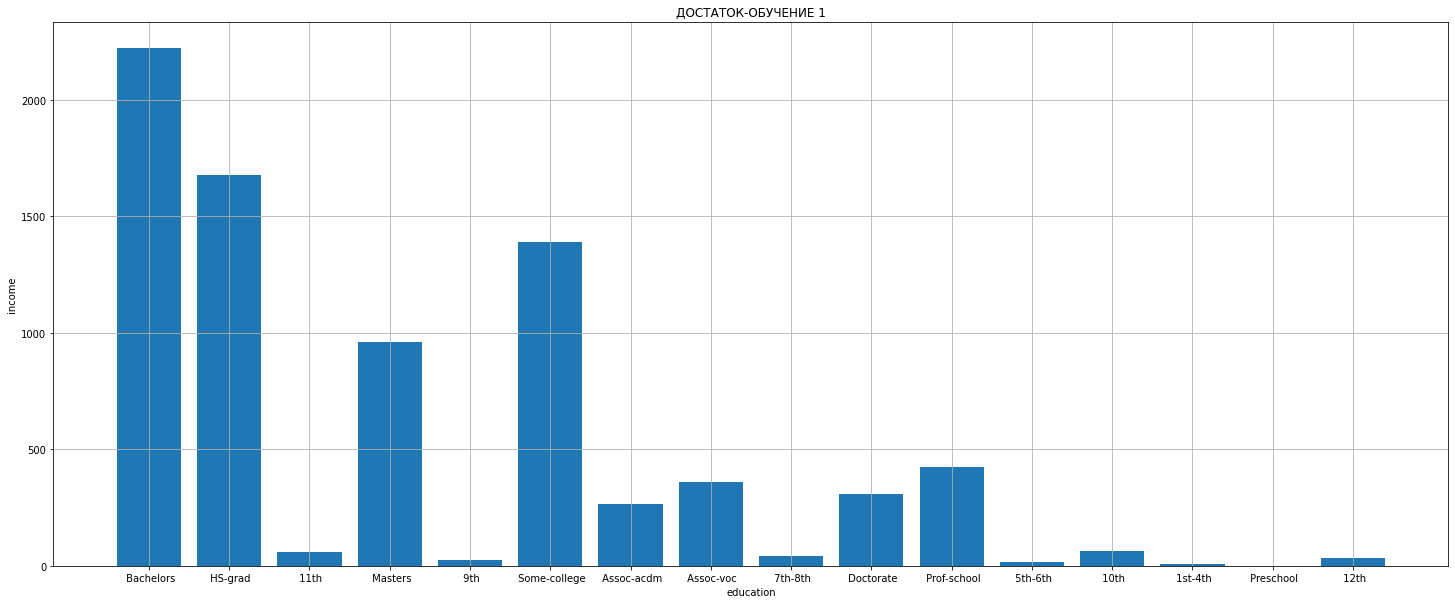

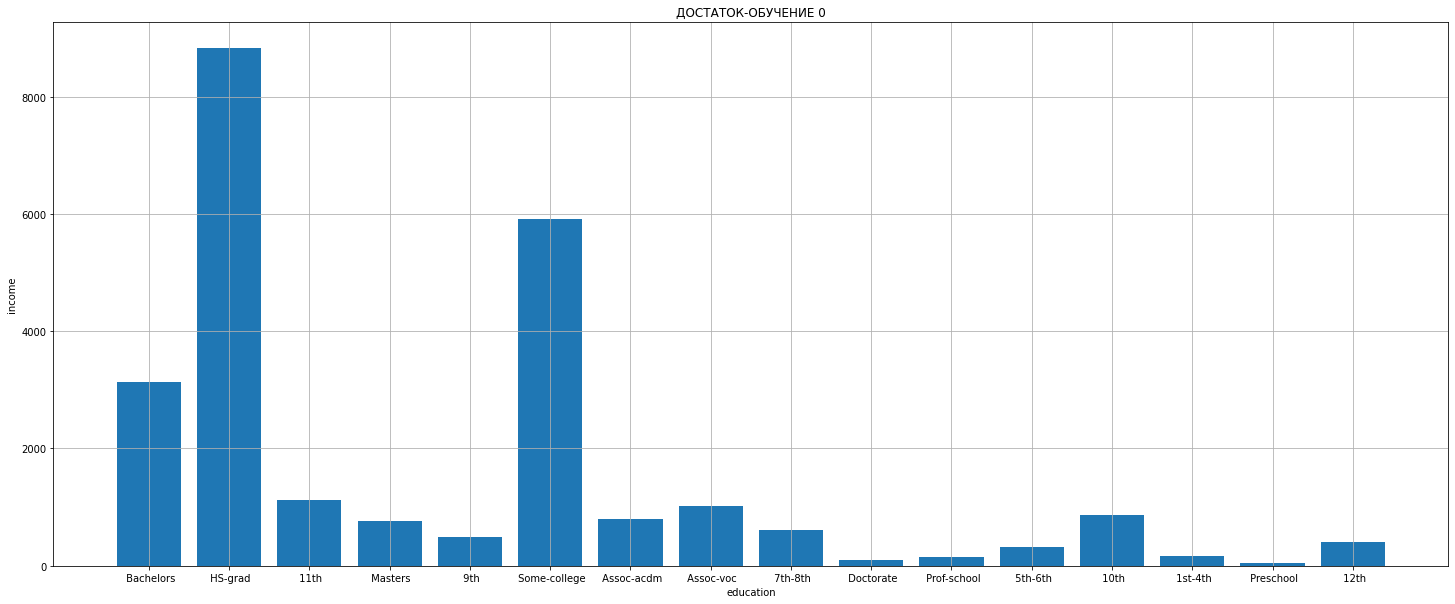

In [49]:
# ДОСТАТОК-ОБУЧЕНИЕ

cls = [' Bachelors', ' HS-grad', ' 11th', ' Masters', ' 9th', ' Some-college',
 ' Assoc-acdm', ' Assoc-voc', ' 7th-8th', ' Doctorate', ' Prof-school',
 ' 5th-6th', ' 10th', ' 1st-4th', ' Preschool', ' 12th']

cls_1 = []
cls_0 = []

for col in cls:
    cls_1.append(train[train.education == col][['income']].income.sum())
    cls_0.append(train[(train.education == col) & (train.income == 0)][['education']].education.count())

fig = plt.figure(figsize= (25,10))
ax1 = fig.add_subplot()
ax1.set_xlabel('education')
ax1.set_ylabel('income')
ax1.set_title('ДОСТАТОК-ОБУЧЕНИЕ 1')
ax1.grid()
ax1.bar(cls, cls_1) 

fig = plt.figure(figsize= (25,10))
ax1 = fig.add_subplot()
ax1.set_xlabel('education')
ax1.set_ylabel('income')
ax1.set_title('ДОСТАТОК-ОБУЧЕНИЕ 0')
ax1.grid()
ax1.bar(cls, cls_0) 

Посмотрим на корреляцию между выделенным признаками и выберем основные коррелирующие признаки.

Видим, что income плохо коррелирует с fnlwgt, поэтому его исключим из дальнеейшего рассмотрения.

In [50]:
train.corr()
# age, education-num, capital-gain, capital-loss, hours-per-week

,age,fnlwgt,education-num,capital-gain,capital-loss,hours-per-week,income
age,1.000000,-0.076646,0.036527,0.077674,0.057775,0.068756,0.234037
fnlwgt,-0.076646,1.000000,-0.043195,0.000432,-0.010252,-0.018768,-0.009463
education-num,0.036527,-0.043195,1.000000,0.122630,0.079923,0.148123,0.335154
capital-gain,0.077674,0.000432,0.122630,1.000000,-0.031615,0.078409,0.223329
capital-loss,0.057775,-0.010252,0.079923,-0.031615,1.000000,0.054256,0.150526
hours-per-week,0.068756,-0.018768,0.148123,0.078409,0.054256,1.000000,0.229689
income,0.234037,-0.009463,0.335154,0.223329,0.150526,0.229689,1.000000


In [51]:
# occupation
for col in train.columns:
    if train[col].dtype == object:
        print(pd.crosstab(train[col], train['occupation']))
        print('\n\n\n')

occupation          Adm-clerical   Armed-Forces   Craft-repair  \
workclass                                                        
 Federal-gov                 317              9             64   
 Local-gov                   283              0            146   
 Private                    2833              0           3195   
 Self-emp-inc                 31              0            106   
 Self-emp-not-inc             50              0            531   
 State-gov                   253              0             56   
 Without-pay                   3              0              1   

occupation          Exec-managerial   Farming-fishing   Handlers-cleaners  \
workclass                                                                   
 Federal-gov                    180                 8                  23   
 Local-gov                      214                29                  47   
 Private                       2691               455                1273   
 Self-emp-inc       

Пара функций для подготовки данных

In [52]:
def delete_NaN(df):
    df['workclass'][df['workclass'].isnull()] = df.describe(include=['object']).loc['top', 'workclass']
    df['occupation'][df['occupation'].isnull()] = df.describe(include=['object']).loc['top', 'occupation']
    df['native-country'][df['native-country'].isnull()] = df.describe(include=['object']).loc['top', 'native-country']

def one_hot(df, col):    
    dfs = pd.get_dummies(df[col], prefix=col)
    df_ = pd.concat([df, dfs], axis=1)
    df_ = df_.drop(col, axis=1)
    return df_

def transform_df(df):
    unique_counts = pd.DataFrame.from_records([(col, df[col].dtype, df[col].nunique()) for col in df.columns],
                          columns=['Column_Name', 'Type', 'Num_Unique']).sort_values(by=['Num_Unique'])
    df_ = df.copy()
    for col in df.columns:
        if (col == 'capital-gain') | (col == 'capital-loss'):
            df_[col] = (df_[col] - df_[col].mean()) / df_[col].std()
        elif (unique_counts[unique_counts['Column_Name'] == col][['Num_Unique']].values[0][0] == 2) & (df_[col].dtype == object):
            values = df_[col].unique()
            df_[col].replace(values, [1, 0], inplace=True) 
        elif (unique_counts[unique_counts['Column_Name'] == col][['Num_Unique']].values[0][0] < 10) & (df_[col].dtype == object):
            df_ = one_hot(df_, col).copy()
        elif  (unique_counts[unique_counts['Column_Name'] == col][['Num_Unique']].values[0][0] >= 10) & (df_[col].dtype == object):
            #df_[col] = df_[col].astype('category')   
            values = df_[col].unique()
            l = [i for i in range(len(values))] 
            df_[col].replace(values, l, inplace=True)
    return df_

In [53]:
X = train.copy()
delete_NaN(X)
X = train.drop(['fnlwgt'], axis=1)
X = X.drop('income', axis=1)
X = transform_df(X).copy()
X.head()

,age,education,education-num,occupation,sex,capital-gain,capital-loss,hours-per-week,native-country,workclass_ Federal-gov,workclass_ Local-gov,workclass_ Never-worked,workclass_ Private,workclass_ Self-emp-inc,workclass_ Self-emp-not-inc,workclass_ State-gov,workclass_ Without-pay,marital-status_ Divorced,marital-status_ Married-AF-spouse,marital-status_ Married-civ-spouse,marital-status_ Married-spouse-absent,marital-status_ Never-married,marital-status_ Separated,marital-status_ Widowed,relationship_ Husband,relationship_ Not-in-family,relationship_ Other-relative,relationship_ Own-child,relationship_ Unmarried,relationship_ Wife,race_ Amer-Indian-Eskimo,race_ Asian-Pac-Islander,race_ Black,race_ Other,race_ White
0,39,0,13,0,1,0.148451,-0.216656,40,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,1
1,50,0,13,1,1,-0.145918,-0.216656,13,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1
2,38,1,9,2,1,-0.145918,-0.216656,40,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1
3,53,2,7,2,1,-0.145918,-0.216656,40,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0
4,28,0,13,3,0,-0.145918,-0.216656,40,1,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0


In [54]:
y = pd.DataFrame(train['income'])
test_ = test.drop('income', axis=1)
delete_NaN(test_)
test_ = test_.drop(['fnlwgt'], axis=1)
test_ = transform_df(test_).copy()
target = pd.DataFrame(test['income'])
test_.head()

,age,education,education-num,occupation,sex,capital-gain,capital-loss,hours-per-week,native-country,workclass_ Federal-gov,workclass_ Local-gov,workclass_ Never-worked,workclass_ Private,workclass_ Self-emp-inc,workclass_ Self-emp-not-inc,workclass_ State-gov,workclass_ Without-pay,marital-status_ Divorced,marital-status_ Married-AF-spouse,marital-status_ Married-civ-spouse,marital-status_ Married-spouse-absent,marital-status_ Never-married,marital-status_ Separated,marital-status_ Widowed,relationship_ Husband,relationship_ Not-in-family,relationship_ Other-relative,relationship_ Own-child,relationship_ Unmarried,relationship_ Wife,race_ Amer-Indian-Eskimo,race_ Asian-Pac-Islander,race_ Black,race_ Other,race_ White
0,25,0,7,0,1,-0.142657,-0.218055,40,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,1,0,0
1,38,1,9,1,1,-0.142657,-0.218055,50,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1
2,28,2,12,2,1,-0.142657,-0.218055,40,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1
3,44,3,10,0,1,0.871064,-0.218055,40,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0
4,18,3,10,3,0,-0.142657,-0.218055,30,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,1


In [55]:
X.to_csv('X_a.csv')
y.to_csv('Y_a.csv')
test_.to_csv('test_a.csv')
target.to_csv('target_a.csv')

Мы выделили основные признаки для рассмотрения данной задачи.

Осталось только обучить модель.